# PAE logp sampling

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
from pae.model_tf2 import get_prior, get_posterior

In [6]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [7]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file  = 'params_fmnist_-1_32_infoGAN_VAE_v2_full_sigma_beta100_C15'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [8]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [9]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)
x_valid = (x_valid/256.-0.5).astype(np.float32)

In [10]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')

Signature: get_prior(latent_size)
Docstring: <no docstring>
File:      /global/u2/v/vboehm/codes/PAE/pae/model_tf2.py
Type:      function


In [11]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

In [26]:
#z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)

encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)


likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))
       
prior         = get_prior(params['latent_size'])

In [27]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [40]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood_   = likelihood(z).log_prob(x)
    return likelihood_

def prior_eval(z, prior):
    prior_         = prior.log_prob(z)
    return prior_

def posterior_eval(z,x,likelihood, prior):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood_  = likelihood_eval(z,x,likelihood)
    prior_       = prior_eval(z, prior)
    logprob      = likelihood_+prior_
    return logprob


class LogP():
    def __init__(self,x):
        self.x = x
        self.z_fill = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)
    
    def logp_grad(self,z):

        self.z_fill.assign(z)
        z_  = tf.convert_to_tensor(self.z_fill)
        
        with tf.GradientTape() as tape:
            tape.watch(z_)
            log_p         = posterior_eval(z_,self.x,likelihood, prior)
        grad = tape.gradient(log_p, [z_])
        return log_p, grad[0]

    @tf.custom_gradient
    def logp(self,z):

        logp, grads = self.logp_grad(z)

        def grad(up,variables=None):
            grad_ = tf.expand_dims(up,-1)*grads

            return grad_, [None for ii in range(len(variables))] 

        return logp, grad

In [41]:
encoder

In [42]:
x     = np.repeat(x_test[0:1], params['batch_size'], axis=0)
LP    = LogP(x)
z_ini = get_encoded(x)

In [43]:
y = LP.logp(z_ini)
#print(y)

In [44]:
z_ = tf.constant(z_ini)
with tf.GradientTape() as g:
    g.watch(z_)
    y = LP.logp(z_)
grad = g.gradient(y, z_)
print(grad)

tf.Tensor(
[[-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]
 [-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]
 [-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]
 ...
 [-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]
 [-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]
 [-2.34636     1.6585486  -0.91524893 ... -0.19258144 -0.20719096
  -1.1789829 ]], shape=(128, 32), dtype=float32)


In [45]:
import time

In [46]:
initial_step_size = np.ones((params['batch_size'],params['latent_size']))*1

In [86]:
# Initialize the HMC transition kernel.
num_results = int(1000)
print(num_results)

def get_kernel(ii,num_burnin_steps, num_lp_steps):
    x     = x_test[ii*params['batch_size']:(ii+1)*params['batch_size']]
    LP    = LogP(x)
    z_ini = get_encoded(x)
    adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=LP.logp,
            num_leapfrog_steps=num_lp_steps,
            step_size=initial_step_size),
            num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP

# Run the chain (with burn-in).
#@tf.function
def run_chain(adapative_hmc, z_ini, num_burnin_steps):
  # Run the chain (with burn-in).
    samples, [step_size, accept_ratio] = tfp.mcmc.sample_chain(
      num_results      = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state    = z_ini,
      kernel           = adaptive_hmc,
      trace_fn         = lambda _, pkr: [pkr.inner_results.accepted_results.step_size,
                             pkr.inner_results.is_accepted])

    return samples, step_size, accept_ratio

1000


In [87]:
10000//128

78

In [88]:
78*128

9984

In [89]:
begin = time.time()
samples_ = []
for ii in range(0,1):
    print(ii)
    for jj, burnin in enumerate([500]):
        for nn, numsteps in enumerate([5]):
            adaptive_hmc, z_ini, LP = get_kernel(ii,burnin,numsteps)
            samples, step_size, accept_ratio = run_chain(adaptive_hmc, tf.convert_to_tensor(z_ini),tf.constant(burnin))
            end = time.time()-begin
            print(end)
            begin = time.time()
    samples_.append(samples)

# print(samples.shape)
# samples = np.swapaxes(np.asarray(samples_),1,2)
# print(samples.shape)
# samples = np.reshape(samples,(-1,num_results,params['latent_size']))
# print(samples.shape)
# np.save(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples/FMNIST/latent_dim32/PAE/samples','HMC_FMNIST_latent_dim%d_burnin%d_leapfrog%d.npy'%(params['latent_size'],burnin,numsteps)),samples)
# # print('time:', end/60)

0
270.03563356399536


In [98]:
samples = np.swapaxes(np.asarray(samples_),1,2)
print(samples.shape)
samples = np.reshape(samples,(-1,num_results,params['latent_size']))
print(samples.shape)

(1, 128, 1000, 32)
(128, 1000, 32)


In [109]:
mean = samples[0].mean(axis=0)

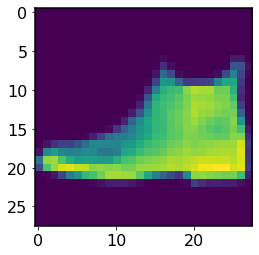

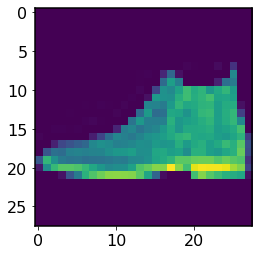

In [114]:
plt.imshow(np.squeeze(get_decoded(build_container(mean))[0]))
plt.show()
plt.imshow(np.squeeze(x_test[0]))

In [115]:
min(np.var(samples[:,:,:],axis=0).flatten())

0.49262598

In [116]:
max(np.mean(accept_ratio[::2],axis=0))

0.934

In [117]:
min(np.mean(accept_ratio[::2],axis=0))

0.732

In [118]:
np.mean(accept_ratio[::2],axis=0)

array([0.856, 0.79 , 0.832, 0.75 , 0.8  , 0.808, 0.798, 0.756, 0.77 ,
       0.734, 0.756, 0.774, 0.818, 0.864, 0.8  , 0.834, 0.784, 0.804,
       0.756, 0.772, 0.788, 0.77 , 0.792, 0.75 , 0.782, 0.802, 0.798,
       0.806, 0.764, 0.828, 0.732, 0.816, 0.782, 0.882, 0.786, 0.816,
       0.79 , 0.826, 0.786, 0.818, 0.854, 0.832, 0.844, 0.842, 0.834,
       0.8  , 0.802, 0.772, 0.794, 0.78 , 0.78 , 0.784, 0.934, 0.812,
       0.832, 0.744, 0.842, 0.746, 0.794, 0.794, 0.834, 0.832, 0.804,
       0.81 , 0.768, 0.814, 0.752, 0.846, 0.822, 0.81 , 0.756, 0.864,
       0.794, 0.822, 0.882, 0.774, 0.806, 0.814, 0.81 , 0.802, 0.862,
       0.808, 0.832, 0.832, 0.806, 0.832, 0.844, 0.79 , 0.84 , 0.732,
       0.786, 0.812, 0.78 , 0.826, 0.784, 0.784, 0.824, 0.782, 0.826,
       0.8  , 0.792, 0.8  , 0.806, 0.74 , 0.818, 0.788, 0.822, 0.788,
       0.818, 0.834, 0.828, 0.76 , 0.784, 0.782, 0.854, 0.812, 0.792,
       0.77 , 0.786, 0.808, 0.744, 0.772, 0.796, 0.842, 0.856, 0.838,
       0.802, 0.802]

In [119]:
import corner

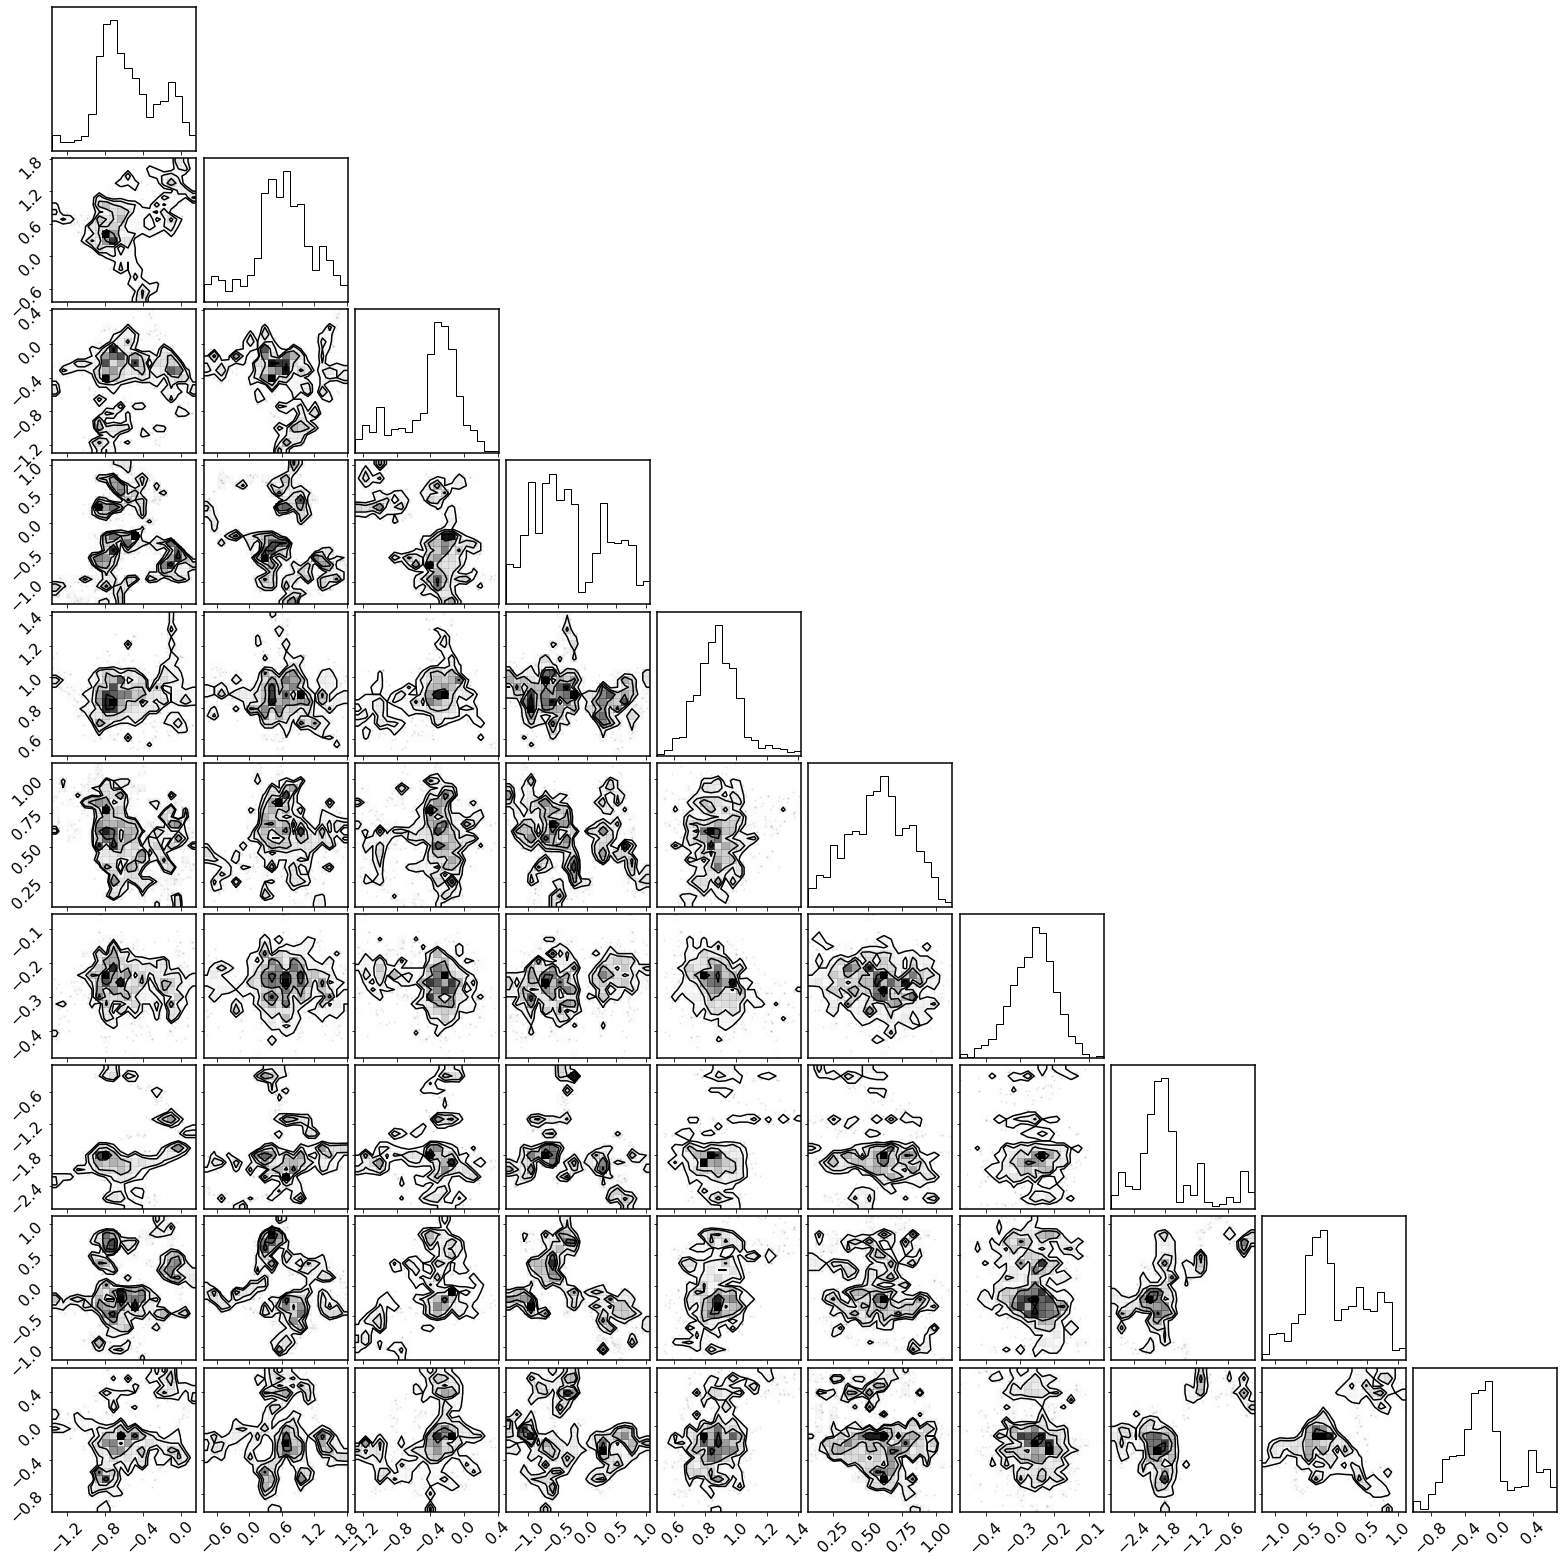

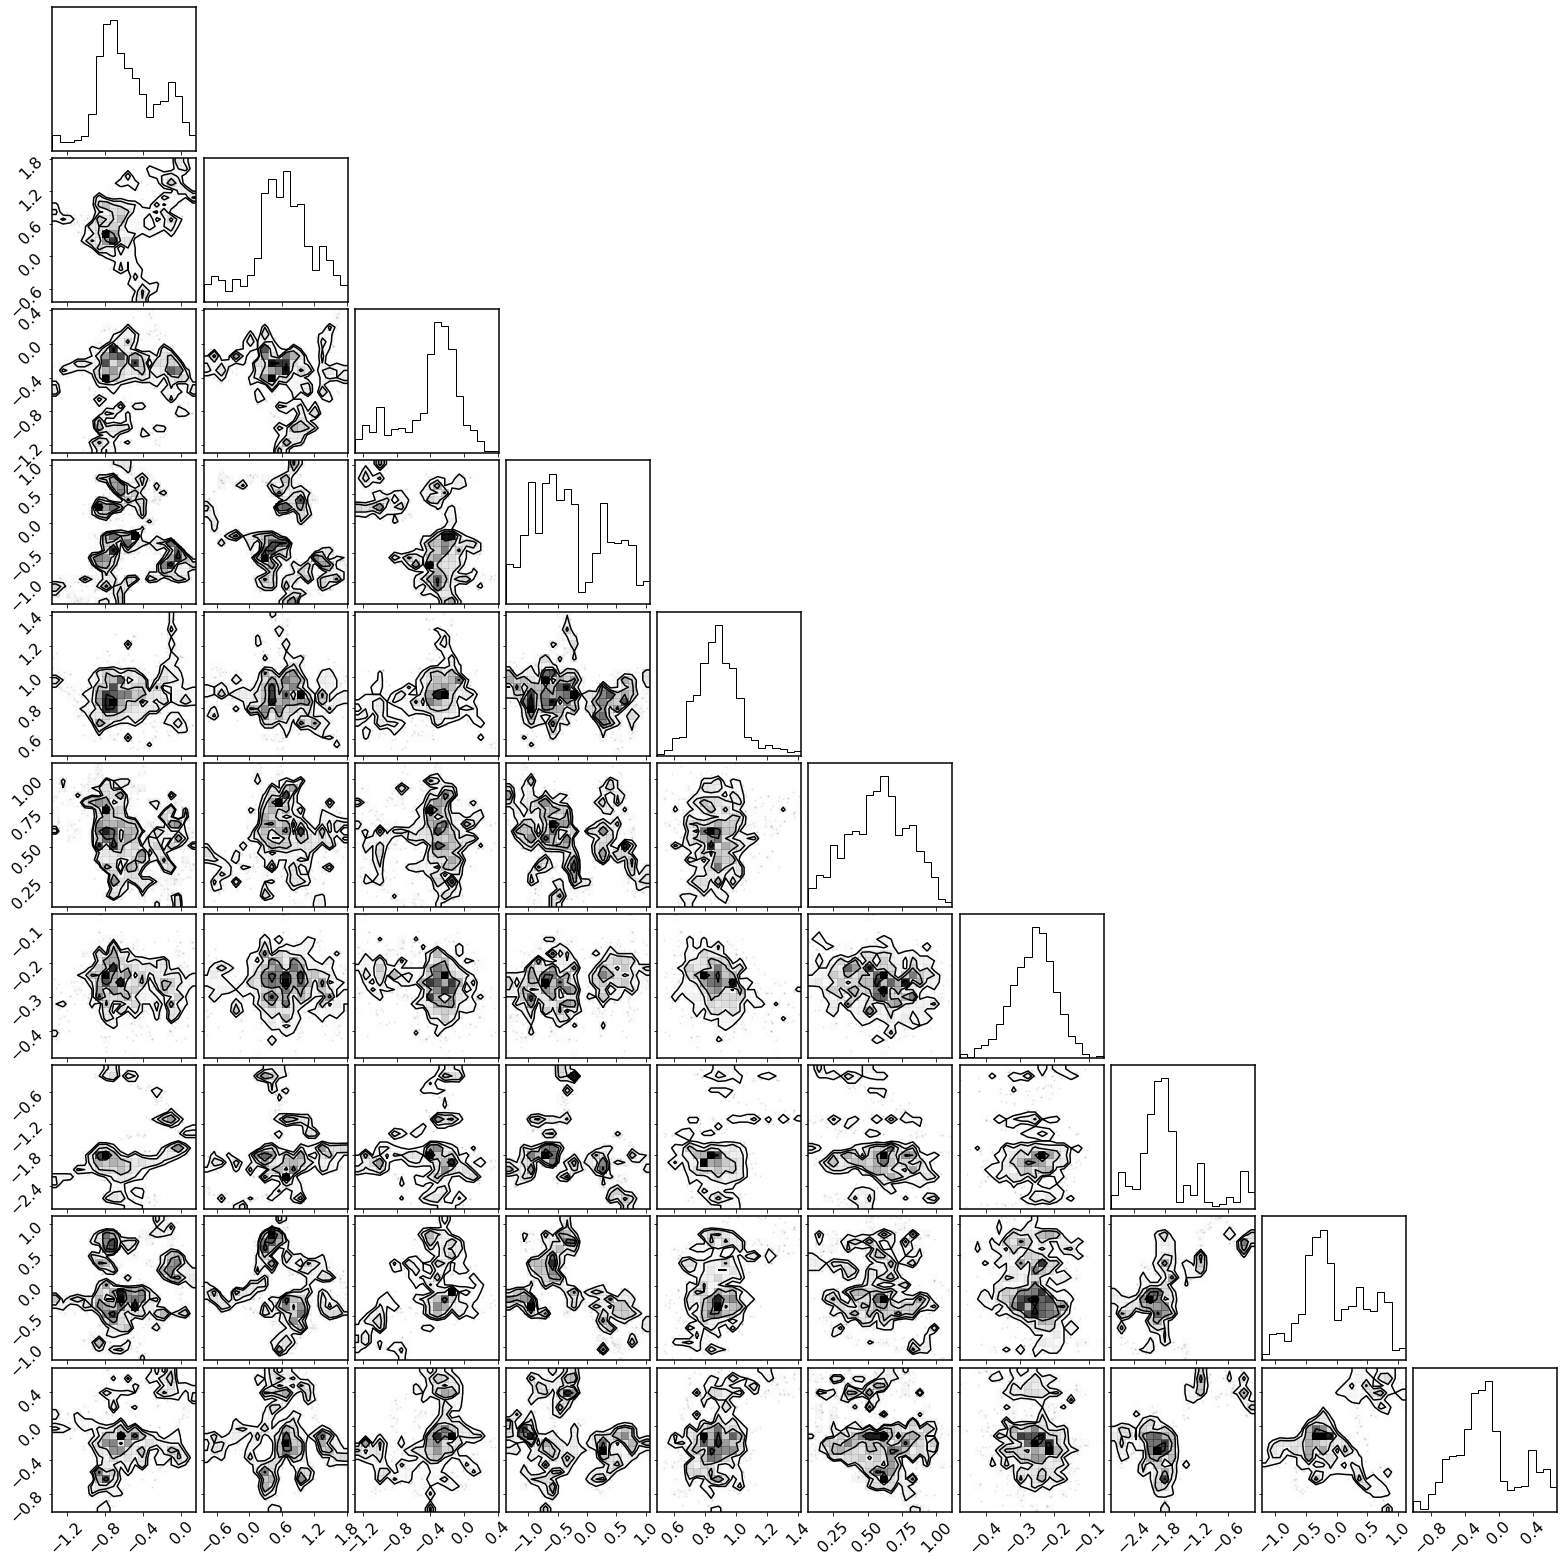

In [120]:
corner.corner(samples[0,:,0:10])

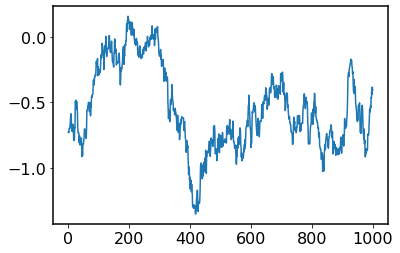

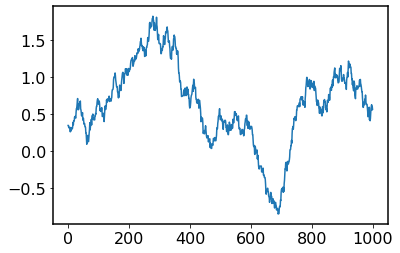

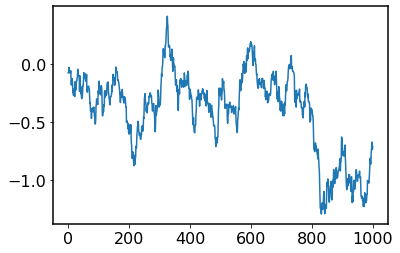

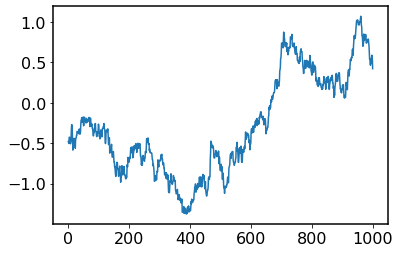

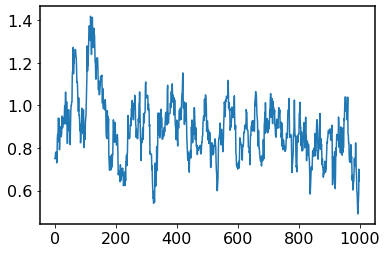

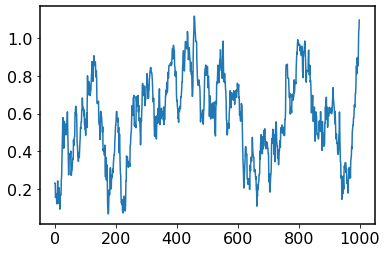

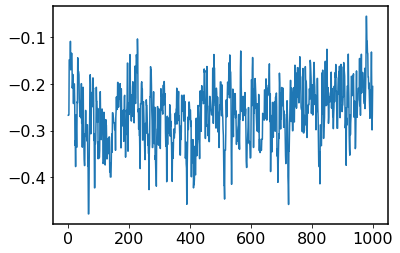

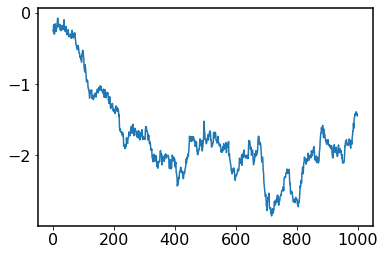

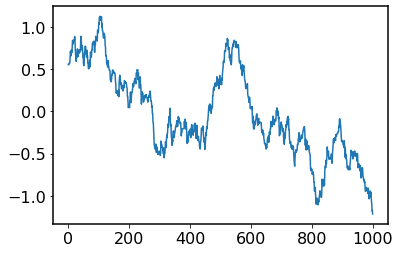

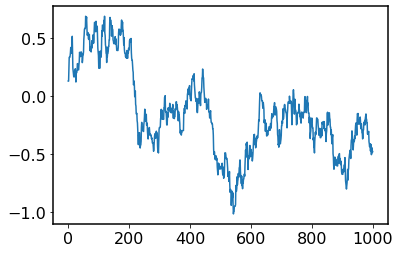

In [100]:
for ii in range(10):
    plt.plot(samples[0,:,ii])
    plt.show()

In [101]:


def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf



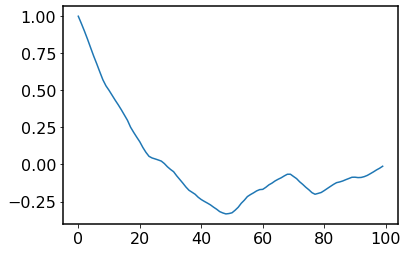

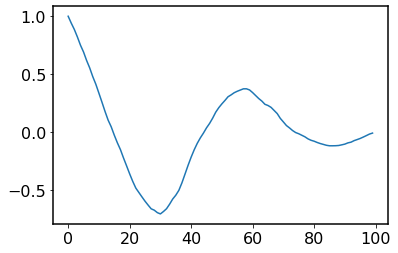

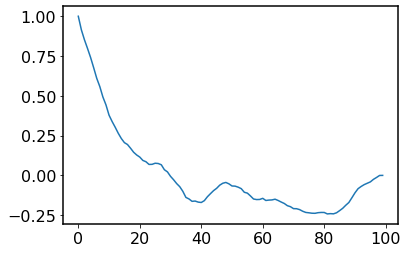

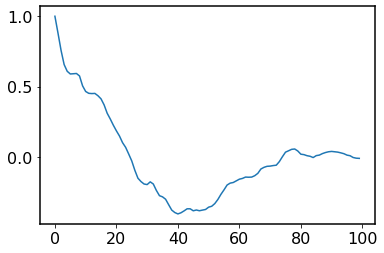

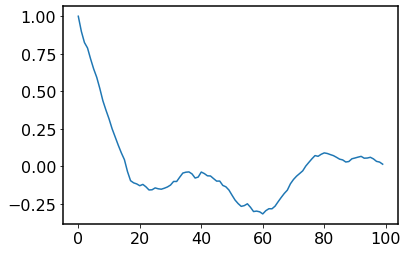

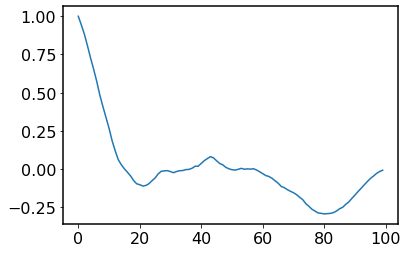

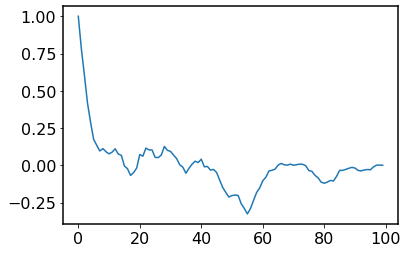

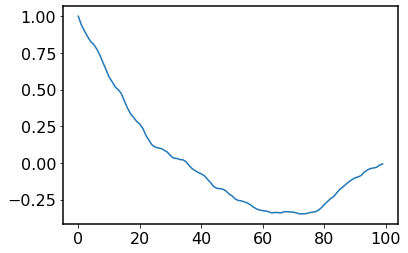

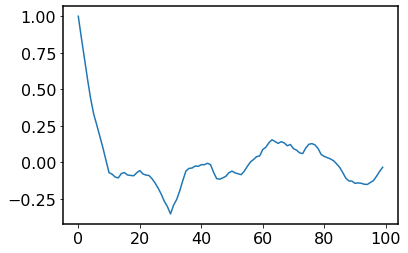

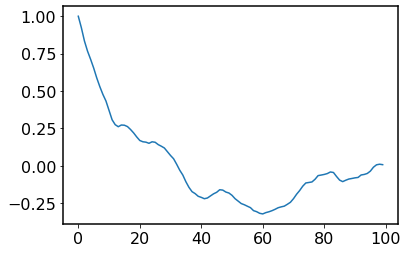

In [102]:


for ii in range(10):
    for n in [100]:
        acf = autocorr_func_1d(samples[0,:n,ii], norm=True)
        plt.plot(acf)
        plt.show()



In [96]:
samples= np.expand_dims(samples,0)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]



In [63]:
N = np.exp(np.linspace(np.log(100), np.log(samples.shape[1]), 20)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for jj in range(10):
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(samples[:, :n,jj])
        new[i] = autocorr_new(samples[:, :n,jj])
    tau_esti = np.mean(new[-4:])
    print(tau_esti)

ValueError: invalid dimensions for 1D autocorrelation function

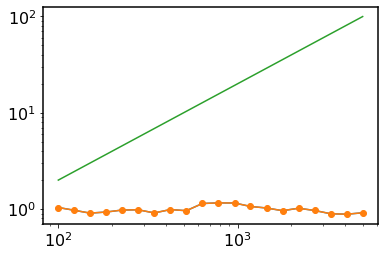

In [50]:
plt.loglog(N,gw2010)
plt.loglog(N,new, marker='o')
plt.loglog(N, N/50)

In [51]:
x_mean  = np.reshape(get_decoded(np.repeat([sample_mean],16,0))[0], (28,28))
plt.title('mean')
plt.imshow(x_mean.reshape(28,28))
plt.axis('off')
plt.show()

NameError: name 'sample_mean' is not defined